In [41]:
# read in data from excel file to dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
import datetime
import time
import math
from scipy import stats
from scipy.stats import norm
from scipy.stats import t

#===================== Independent Constants =====================
class EnvConstants:
    """Environmental constants for atmospheric and crop conditions with units and descriptions.

    Attributes:
        P (float): Atmospheric pressure (kPa).
        zm (float): Measurement height for wind speed (m).
        k (float): von Karman's constant (none).
        esurface (float): Emissivity of crop (none).
        sigma (float): Stefan-Boltzmann constant (W m-2 K-4).
        KR (int): Parameter in Equ (24.2) (W m-2).
        KD1 (float): Parameter in Equ (24.6) (kPa-1).
        KD2 (float): Parameter in Equ (24.6) (kPa-2).
        TL (float): Parameter in Equ (24.4) and Equ (24.5) (K).
        T0 (float): Parameter in Equ (24.4) and Equ (24.5) (K).
        TH (float): Parameter in Equ (24.4) and Equ (24.5) (K).
        KM1 (float): Parameter in Equ (24.6) (none).
        KM2 (float): Parameter in Equ (24.6) (mm-1).
        ra (float): Moist Air density (kg m-3).
        cp (float): Specific heat capacity of air at constant pressure (J kg-1 K-1).
        gc (float): Canopy cover factor (none).
        aT (float): Parameter in temperature stress factor (none).
        zo_prime (float): Aerodynamic roughness of soil (m).
    """
    P: float = 101.20  # Atmospheric pressure
    zm: float = 50.00  # Measurement height for wind speed
    k: float = 0.4  # von Karman's constant
    esurface: float = 0.95  # Emissivity of crop
    sigma: float = 5.67E-08  # Stefan-Boltzmann constant
    KR: int = 200  # Parameter in Equ (24.2)
    KD1: float = -0.307  # Parameter in Equ (24.6)
    KD2: float = 0.019  # Parameter in Equ (24.6)
    TL: float = 273.00  # Parameter in Equ (24.4) and Equ (24.5)
    T0: float = 293.00  # Parameter in Equ (24.4) and Equ (24.5)
    TH: float = 313.00  # Parameter in Equ (24.4) and Equ (24.5)
    KM1: float = 3.36E-04  # Parameter in Equ (24.6)
    KM2: float = -0.10  # Parameter in Equ (24.6)
    ra: float = 1.23  # Moist Air density
    cp: float = 1013.00  # Specific heat capacity of air
    gc: float = 1.00  # Canopy cover factor
    aT: float = 1.00  # Parameter in temperature stress factor
    zo_prime: float = 0.003  # Aerodynamic roughness of soil

#===================== Crop Dependent Constants =====================

class ForestConstants:
    """Forest environmental constants with units and descriptions.

    Attributes:
        LAI (float): Leaf Area Index (none).
        h (float): Canopy Height (m).
        a (float): Albedo (none).
        g0 (float): Canopy Specific Constant (mm s-1).
        SMo (float): Maximum soil moisture accessible to roots. Parameter in Equ (24.6) (mm).
        SMinit (float): Initial Root-accessible soil moisture (mm).
        S (float): Maximum Canopy Water Storage (mm).
        d (float): Zero plane displacement height (m).
        z0 (float): Aerodynamic roughness of crop (m).
    """
    LAI: float = 4.00  # Leaf Area Index
    h: float = 20.00  # Canopy Height
    a: float = 0.12  # Albedo
    g0: float = 15.00  # Canopy Specific Constant
    SMo: float = 80.00  # Maximum soil moisture accessible to roots
    SMinit: float = 40.00  # Initial Root-accessible soil moisture
    S: float = 4.00  # Maximum Canopy Water Storage
    d: float = 14.644  # Zero plane displacement height
    z0: float = 1.607  # Aerodynamic roughness of crop

class GrassConstants:
    """Grass environmental constants with units and descriptions.

    Attributes:
        LAI (float): Leaf Area Index (none).
        h (float): Canopy Height (m).
        a (float): Albedo (none).
        g0 (float): Canopy Specific Constant (mm s-1).
        SMo (float): Maximum soil moisture accessible to roots. Parameter in Equ (24.6) (mm).
        SMinit (float): Initial Root-accessible soil moisture (mm).
        S (float): Maximum Canopy Water Storage (mm).
        d (float): Zero plane displacement height (m).
        z0 (float): Aerodynamic roughness of crop (m).
    """
    LAI: float = 2.00  # Leaf Area Index
    h: float = 0.12  # Canopy Height
    a: float = 0.23  # Albedo
    g0: float = 30.00  # Canopy Specific Constant
    SMo: float = 40.00  # Maximum soil moisture accessible to roots
    SMinit: float = 10.00  # Initial Root-accessible soil moisture
    S: float = 2.00  # Maximum Canopy Water Storage
    d: float = 0.077  # Zero plane displacement height
    z0: float = 0.013  # Aerodynamic roughness of crop

#==================== Model forcing data ==========================
excel_file = "Lab1.xlsx"
# Read the data from the Excel file, skipping rows so that headers start from row 11 (indexing starts from 0)
forest_data = pd.read_excel(excel_file, header=0, sheet_name = "Forest", skiprows=10)
grass_data = pd.read_excel(excel_file, sheet_name="Grass", header=0, skiprows=10) 

print(forest_data.columns)

Index(['Total Hour', ' Hour', 'SW_in', 'LW_down', 'Ta', 'um', 'q', 'p', 'ra',
       'e', 'esat(T)', 'D', 'Tk', 'gR', 'gD', 'gT', 'gSM', 'SMlast', 'gs',
       'rs', 'Lu', 'Rn', 'lambda', 'delta', 'psyc', 'Cinterim', 'Cactual',
       'Dcanopy', 'C/S', 'lambda*EI (C=Cactual)', 'Cfinal', 'lambda*ET',
       'lambda*Etotal', 'H', 'Tsurface', 'SMnew'],
      dtype='object')


c:\Users\adunw\miniconda3\envs\EcoHydro\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\adunw\miniconda3\envs\EcoHydro\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [42]:
# Part A: Aerodynamic Parameterization. 

def calc_d(h, LAI):
    """
    Calculate zero plane displacement height using constants from either ForestConstants or Grasscrop_constants.

    :param h: Canopy height (m). Crop constant.
    :param LAI: Leaf Area Index (none). Crop constant.
    :return: Zero plane displacement height (m).
    """
    return 1.1 * h * np.log(1 + (LAI / 5)**0.25)  # TH Eq 22.2

def calc_zo(h, d, LAI):
    """
    Calculate aerodynamic roughness of crop 
    :param h: Canopy height (m). Crop constant.
    :param d: Zero plane displacement height (m).
    :param LAI: Leaf Area Index (none). Crop constant.
    :return: Aerodynamic roughness of crop (m).
    """

    if LAI > 1:
        return 0.3 * h * (1 - d / h)  # TH Eq 22.4
    else:
        return EnvConstants.zo_prime + 0.29 * h * (LAI / 5) ** 0.5  # TH Eq 22.3

def calc_ra(d, zo, um):
    """
    Calculate aerodynamic resistance using constants from Environmentalcrop_constants.
    :param zm: Measurement height for wind speed (m). Environmental constant.
    :param d: Zero plane displacement height (m).
    :param zo: Aerodynamic roughness of crop (m).
    :param um: Wind speed at measurement height (m s-1).
    :param k: von Karman's constant (none). Environmental constant.
    :return: Aerodynamic resistance (s m-1).
    """
    k = EnvConstants.k
    zm = EnvConstants.zm
    return 1 / (k**2 * um) * np.log((zm - d) / zo)**2  # TH Eq 22.1



In [43]:
# Part B: Surface Resistance Parameterization

def calc_gR(SW_in):
    """
    Calculate resistance to soil heat flux
    :param SW_in: Incoming shortwave radiation (W m-2).
    :param KR: Parameter in Equ (24.2) (W m-2). Environemntal constant.
    :return: Resistance to soil heat flux (none).
    """
    KR = EnvConstants.KR
    gR =  SW_in * (1000 + KR) / (1000 * (SW_in + KR)) # Eq. 24.2 TH
    return gR.clip(lower=0.0001) # Clip to ensure gR is non-negative

def calc_gD(D):
    """
    Calculate resistance to vapor pressure deficit
    :param D: Vapor pressure deficit (kPa).
    :param KD1: Parameter in Equ (24.6) (kPa-1). Environemntal constant.
    :param KD2: Parameter in Equ (24.6) (kPa-2). Environemntal constant.
    :return: Resistance to vapor pressure deficit (none).
    """
    KD1 = EnvConstants.KD1
    KD2 = EnvConstants.KD2
    gD = 1 + KD1 * D + KD2 * D**2 # Eq. 24.3 TH
    return gD.clip(lower=0.00001)
    
def calc_gT(T):
    """
    Calculate resistance to temperature
    :param T: Temperature (K).
    :param TL: Parameter in Equ (24.4) and Equ (24.5) (K). Environemntal constant.
    :param T0: Parameter in Equ (24.4) and Equ (24.5) (K). Environemntal constant.
    :param TH: Parameter in Equ (24.4) and Equ (24.5) (K). Environemntal constant.
    :param aT: Parameter in temperature stress factor (none). Environemntal constant.
    :return: Resistance to temperature (none).
    """
    TL = EnvConstants.TL
    T0 = EnvConstants.T0
    TH = EnvConstants.TH
    aT = EnvConstants.aT
    gT = ((T - TL) * (TH - T)**aT) / ((T0 - TL) * (TH - T0)**aT) # Eq. 24.4 TH, problem statemnt B.1
    return gT.clip(lower=0.00001)

def calc_gSM(SM, SMo): 
    """
    Calculate resistance to soil moisture flux
    :param SM: Soil moisture (mm).
    :param SMo: Maximum soil moisture accessible to roots. Parameter in Equ (24.6) (mm).
    :param KM1: Parameter in Equ (24.6) (none). Environemntal constant.
    :param KM2: Parameter in Equ (24.6) (mm-1). Environemntal constant.
    :return: Resistance to soil moisture flux (none).
    """
    KM1 = EnvConstants.KM1
    KM2 = EnvConstants.KM2
    
    gSM = 1 - KM1 * np.exp(KM2 * (SM - SMo))
    return gSM.clip(lower=0.00001)

def calc_gs(gR, gD, gT, gSM, g0):
    """
    Calculate total surface conductance
    :param gR: Resistance to soil heat flux (none).
    :param gD: Resistance to vapor pressure deficit (none).
    :param gT: Resistance to temperature (none).
    :param gSM: Resistance to soil moisture flux (none).
    :param g0: Canopy Specific Constant (mm s-1). Crop constant.
    :return: Total surface conductance (mm s-1).
    """
    gs = (gR * gD * gT * gSM * g0) # Eq. 24.1 TH
    return gs.clip(lower=0.00001)

def calc_rs(gs):
    """
    Calculate total surface resistance
    :param gs: Total surface conductance (mm s-1).
    :return: Total surface resistance (s mm-1).
    """
    rs = 1 / gs # Eq. 24.1 TH
    return rs.clip(upper = 10**6)
    
def calc_esat(T):
    """
    Calculate saturation vapor pressure from temperature
    :param T: Temperature (K).
    :return: Saturation vapor pressure (kPa).
    """
    esat = 0.6108 * np.exp(17.27 * T / (T + 237.3)) # Eq. 2.17 TH
    return esat

def calc_e(q):
    """
    Calculate vapor pressure from specific humidity and pressure
    :param q: Specific humidity (kg kg-1).
    :param P: Atmospheric pressure (kPa). Environemntal constant.
    :return: Vapor pressure (kPa).
    """
    P = EnvConstants.P
    e = P * q / 0.622 # Eq 2.9 TH
    return e

def calc_D(esat, e):
    """
    Calculate vapor pressure deficit
    :param esat: Saturation vapor pressure (kPa).
    :param e: Vapor pressure (kPa).
    :return: Vapor pressure deficit (kPa).
    """
    D = esat - e # Eq 2.10 TH
    return D


In [44]:
#Part C: Radiation Parameterization

def calc_Ts(Ta, H, ra):
    """
    Calculate surface temperature
    :param Ta: Air temperature (K).
    :param H: Sensible heat flux (W m-2).
    :param ra: Aerodynamic resistance (s m-1).
    :param rho_a: Moist Air density (kg m-3). Environmental Constant.
    :param cp: Specific heat capacity of air (J kg-1 K-1). Environmental Constant.
    :return: Surface temperature (K).
    """
    cp = EnvConstants.cp
    rho_a = EnvConstants.ra
    Ts = Ta + (H *ra / rho_a / cp) # Eq 21.30 TH
    return Ts

def calc_LW_up(T_s):
    """
    Calculate long wave radiation from surface temperature and emissivity.
    :param T_s: Surface temperature (K).
    :param emissivity: Emissivity of crop (none). Environmental constant.
    :param sigma: Stefan-Boltzmann constant (W m-2 K-4). Environmental constant.
    :return: Long wave radiation from surface (W m-2).
    """
    sigma = EnvConstants.sigma
    emissivity = EnvConstants.esurface
    LWup = emissivity * sigma * (T_s)**4
    return LWup

def calc_Rn(SW_in, a, LW_up, LW_down):
    """
    Calculate net radiation
    :param SW_in: Incoming shortwave radiation (W m-2).
    :param a: Albedo (none). Crop Constant.
    :param LW_up: Long wave radiation from surface (W m-2).
    :param LW_down: Long wave radiation from atmosphere (W m-2).
    :return: Net radiation (W m-2).
    """
    LW_net = LW_up - LW_down
    Rn = (1 - a) * SW_in + LW_net # Eq 24.7 TH
    return Rn

In [45]:


#Part D.1 Canopy Water Balance Parameterization (Includes Interception) 

def calc_delta(T, e_sat):
    """
    Calculate gradient of the saturation vapor pressure curve from saturation vapor pressure and temperature
    e_sat: saturation vapor pressure in kPa
    T: temperature in degrees Celsius
    return: slope of the saturation vapor pressure curve in kPa/°C
    """

    delta = 4098 * e_sat / (T + 237.3)**2 # Eq 2.18 TH, problem statement D.1.1
    return delta


def calc_LH(T):
    """
    Calculate latent heat of vaporization from temperature
    T: temperature in degrees Celsius
    return: latent heat of vaporization (lambda) in MJ/kg
    """
    LH = 2.501 - 0.002361 * T # Eq 2.1 TH, problem statement D.1.1
    return LH

def calc_psy_const(LH):
    """
    Calculate psychrometric constant
    c_p: specific heat of dry air at constant pressure in kJ/kg/K
    P: pressure in kPa
    LH: latent heat of vaporization in MJ/kg
    return: psychrometric constant in kPa/°C
    """
    cp = EnvConstants.cp / 1000 # convert from kJ/kg/K to MJ/kg/K
    P = EnvConstants.P
    psychrometric_constant = cp * P / (0.622 * LH) # Eq. 2.25 TH, problem statement D.1.1
    return psychrometric_constant

def calc_lambdaE(lambdaEl, C, S, lambdaET):
    """
    Calculate total evaporation rate
    :param lambdaEl: evaporation rate of intercepted rainfall with free water canopy in W m-2
    :param C: canopy storage in mm
    :param S: maximum canopy storage in mm
    :param lambdaET: transpiration rate in W m-2
    return: total evaporation rate in W m-2
    """
    lambdaE = lambdaEl + (1 - C/S) * lambdaET # Eq 22.17 TH, problem statement D.1.2
    return lambdaE

def calc_dCdT(p, lambdaEl, D):
    """
    Calculate change in canopy drainage with respect to temperature
    :param p: precipitation in mm
    :param lambdaEl: evaporation rate of intercepted rainfall with free water canopy in W m-2
    :param D: vapor pressure deficit in kPa
    return: change in canopy drainage with respect to temperature in mm/h
    """
    ft = 0
    fs = 0
    dCdT = p*(1 - ft - fs) - lambdaEl - D # Eq 22.15 TH, problem statement D.1.3
    return dCdT

def calc_lambdaEl(delta, ra, Rn, psy_const, D):
    """
    Calculate evaporation rate of intercepted rainfall with free water canopy
    :param delta: slope of the saturation vapor pressure curve in kPa/°C
    :param ra: aerodynamic resistance in s/m
    :param Rn: net radiation in W/m^2
    :param psy_const: psychrometric constant in kPa/°C
    :param rho_a: moist air density in kg/m^3. Environmental constant.
    :param D: vapor pressure deficit in kPa
    return: evaporation rate of intercepted rainfall with free water canopy in W m-2
    """
    CS = 1
    A = Rn # Available energy = net radiation problem statement D.1.8
    Dref = D # VPD at reference level above canopy in kPa
    rho_a = EnvConstants.ra
    cp = EnvConstants.cp
    lambdaEl = CS * delta * A + (rho_a * cp * Dref / ra) / (delta + psy_const) # Eq 22.14 TH, problem statement D.1.4

def calc_Cinterim(p, Cfinal):
    """
    Calculate interim canopy drainage
    :param p: precipitation in mm
    :param Cfinal: final canopy storage in mm
    return: interim canopy storage in mm
    """
    Cinterim = p + Cfinal # Given in problem statement D.1.6
    return Cinterim

def calc_Cactual(Cinterim, S):
    """
    Calculate actual canopy storage
    :param Cinterim: interim canopy storage in mm
    :param S: maximum canopy storage in mm
    return: actual canopy storage in mm
    """
    if Cinterim > S: # Given in problem statement D.1.7
        Cactual = S
    else:
        Cactual = Cinterim # Given in problem statement D.1.7
    return Cactual

def calc_Dcanopy(Cinterim, S):
    """
    Calculate canopy drainage
    :param Cinterim: interim canopy storage in mm
    :param S: maximum canopy storage in mm
    return: canopy drainage in mm
    """
    if Cinterim > S: # Given in problem statement D.1.7
        Dcanopy = Cinterim - S
    else:
        Dcanopy = 0 # Given in problem statement D.1.7
    return Dcanopy

def calc_Cfinal(lambdaEl, Cactual, LH):
    """
    Calculate final canopy storage
    :param lambdaEl: evaporation rate of intercepted rainfall with free water canopy in W m-2
    :param Cactual: actual canopy storage in mm
    :param LH: latent heat of vaporization in MJ/kg
    return: final canopy storage in mm
    """
    lambdaEl_mm = lambdaEl * 3600 / LH # Convert from W m-2 to mm/h
    Cfinal = Cactual - lambdaEl_mm # Problem statement D.1.9
    return Cfinal

def calc_lambdaE_total(lambdaEl, Cactual, S, lambdaET):
    """
    Calculate total evaporation rate
    :param lambdaEl: evaporation rate of intercepted rainfall with free water canopy in W m-2
    :param Cactual: actual canopy storage in mm
    :param S: maximum canopy storage in mm
    :param lambdaET: transpiration rate in W m-2
    """
    lambdaE = lambdaEl + (1 - Cactual / S) * lambdaET # Eq 22.17 TH, problem statement D.1.11
    return lambdaE

def calc_H(R_n, lambdaE):
    """
    Calculate turbulent sensible heat flux from net radiation, evaporation rate, and heat flux into the ground.
    :param R_n: Net radiation (W m-2).
    :param lambdaE: Evaporation rate (W m-2).
    return: Sensible heat flux (W m-2).
    """
    H = H = R_n - lambdaE # Given in problem statement D.1.1 & D.1.12
    return H


In [46]:
# Part E Soil Water Balance Parameterization

def calc_SMnew(Dcanopy, Cactual, S, lambdaET, SMo):
    """
    Calculate new soil moisture
    :param SMlast: Previous soil moisture (mm).
    :param Dcanopy: Canopy water storage change (mm).
    :param Cactual: Actual canopy water storage (mm).
    :param S: Maximum canopy water storage (mm). Crop constant.
    :param lambdaET: Evapotranspiration (mm).
    :param SMo: Maximum soil moisture accessible to roots (mm). Crop constant.
    :return: New soil moisture (mm).
    """
    SMnew = Dcanopy - (1 - Cactual / S) * lambdaET # problem statement E.1
    # Ensure SMnew does not exceed soil moisture holding capacity
    SMnew = min(SMnew, SMo) #problem statement E.2
    #forest_data['SMlast'] = SMnew
    return SMnew


In [47]:
def run_model(data, crop_constants):
    """
    Run the model on the given dataset using functions defined above.
    Write the results to a csv file.

    :param data: DataFrame containing either crop data.
    :param crop_constants: Dictionary of constants specific to the crop.
    """
    data['q'] = data['q'] / 1000 # Convert specific humidity from g/kg to kg/kg
    data['Tk'] = data['Ta'] + 273.17 # Convert temperature from Celsius to Kelvin
    
    # Aerodynamic Parameterization
    data['d'] = calc_d(crop_constants.h, crop_constants.LAI) # A.1
    data['z0'] = calc_zo(crop_constants.h, data['d'], crop_constants.LAI) # A.1
    data['ra'] = calc_ra(data['d'], data['z0'], data['um']) # A.2
    
    # Surface Resistance Parameterization
    data['SMlast'] = crop_constants.SMinit
    data['esat(T)'] = calc_esat(data['Ta'])
    data['e'] = calc_e(data['q'])
    data['D'] = calc_D(data['esat(T)'], data['e'])
    data['gR'] = calc_gR(data['SW_in'])
    data['gD'] = calc_gD(data['D'])
    data['gT'] = calc_gT(data['Tk'])
    #++++++++++++++SM NOT CALCULATED YET++++++++++++++
    data['gSM'] = calc_gSM(data['SMlast'], crop_constants.SMo)
    data['gs'] = calc_gs(data['gR'], data['gD'], data['gT'], data['gSM'], crop_constants.g0)
    data['rs'] = calc_rs(data['gs'])
    #++++++++++++++++++++++++++++++++++++++++++++++++

    # LW and Rn Calculations
    data['LW_up'] = calc_LW_up(data['Tk'])
    data['Rn'] = calc_Rn(data['SW_in'], crop_constants.a, data['LW_up'], data['LW_down'])
    
    # Canopy Water Balance Parameterization
    data['delta'] = calc_delta(data['Ta'])
    data['LH'] = calc_LH(data['Ta'])
    data['psy_const'] = calc_psy_const(data['LH'])
    data['lambdaEl'] = calc_lambdaEl(data['delta'], data['ra'], data['psy_const'], ra, data['D'])
    data['lambdaE'] = calc_lambdaE(data['lambdaEl'], data['CS'], data['lambdaET'])
    data['dCdT'] = calc_dCdT(data['p'], data['lambdaEl'], data['D'])

    data['Cinterim'] = calc_Cinterim(data['p'], data['Cfinal'])
    data['Cactual'] = calc_Cactual(data['Cinterim'], crop_constants.S)
    data['Dcanopy'] = calc_Dcanopy(data['Cinterim'], crop_constants.S)
    data['Cfinal'] = calc_Cfinal(data['lambdaEl'], data['Cactual'], data['LH'])
    data['lambdaE_total'] = calc_lambdaE_total(data['lambdaEl'], data['Cactual'], crop_constants.S, data['lambdaET'])
    data['H'] = calc_H(data['Rn'], data['lambdaE_total'])
    
    # Soil Water Balance Parameterization
    data['SMnew'] = calc_SMnew(data['Dcanopy'], data['Cactual'], crop_constants.S, data['lambdaET'], crop_constants.SMo)

    # Radiation Parameterization
    data['Ts'] = calc_Ts(data['Ta'], data['H'], data['ra'])

forest_constants = ForestConstants()
grass_constants = GrassConstants()
# Example usage with the provided datasets
run_model(forest_data, forest_constants)
run_model(grass_data, grass_constants)

# After processing, you can export the modified datasets to CSV files
forest_data.to_csv('processed_forest_data.csv', index=False)
grass_data.to_csv('processed_grass_data.csv', index=False)




NameError: name 'P' is not defined

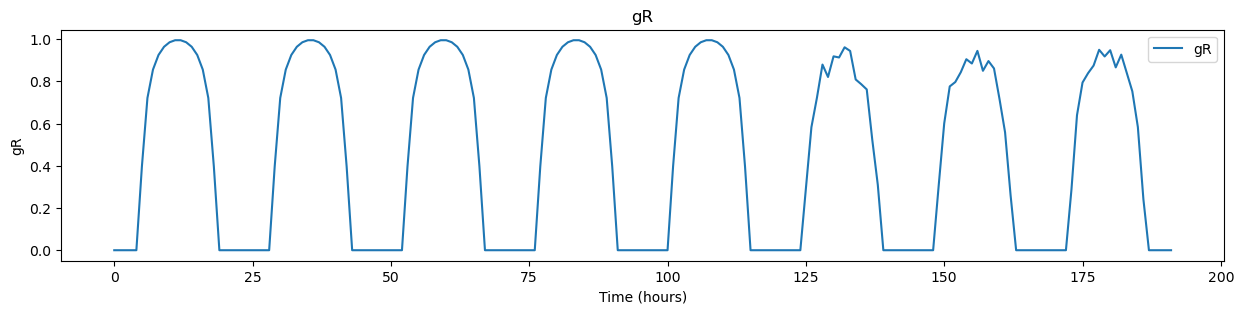

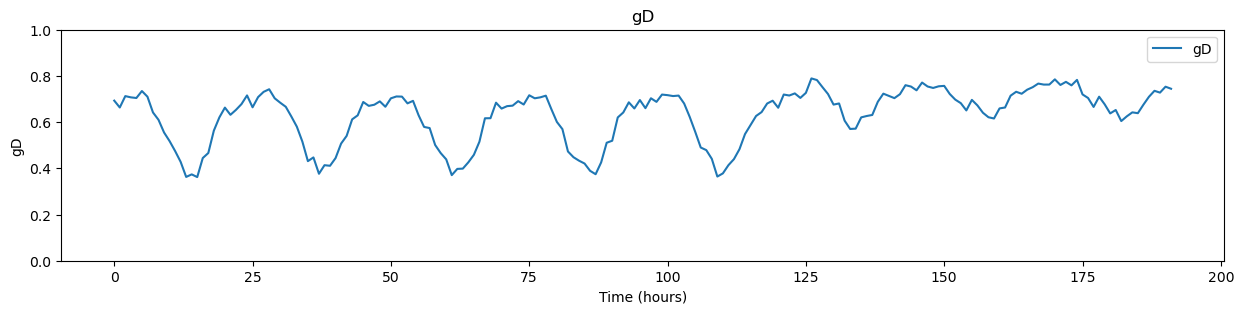

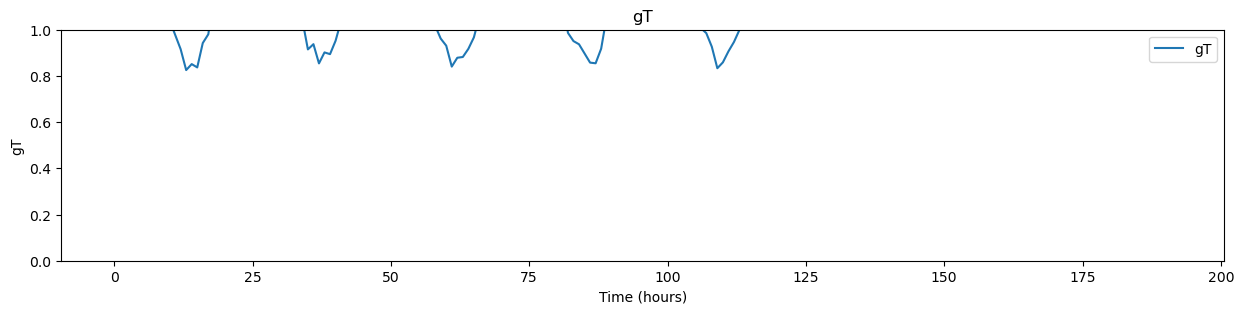

In [ ]:
#Plot the data

# Plot gR wide layout with y min of 0
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(forest_data['gR'], label='gR')
ax.set_title('gR')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('gR')
ax.legend()
plt.show()


#Plot gD wide layout with y min of 0
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(forest_data['gD'], label='gD')
ax.set_title('gD')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('gD')
ax.set_ylim(0, 1)
ax.legend()
plt.show()


#Plot gT wide layout
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(forest_data['gT'], label='gT')
ax.set_title('gT')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('gT')
ax.set_ylim(0, 1)
ax.legend()
plt.show()


In [ ]:

# D.2 Canopy Transpiration.
#This section currently unused. Section D.1 used instead.

def calc_lambdaET_dry_D2(delta, Rn, ra, rs, psy_const, rho_a, Dref):
    """
    Calculate transpiration rate
    delta: gradient of the saturation vapor pressure curve in kPa/°C
    Rn: net radiation in W/m^2
    ra: aerodynamic resistance in s/m
    psy_const: psychrometric constant in kPa/°C
    rho_a: air density in kg/m^3
    Dref: observed VPD at reference level above canopy in kPa
    return: transpiration rate in W/m^2
    """
    A = Rn # Available energy = net radiation problem statement D.2.1
    lambdaET_dry = delta * A + (rho_a * cp * Dref / ra) / (delta + psy_const * (1 + ra / rs)) # Eq 22.18 TH, problem statement D.2.1
    return lambdaET_dry

def calc_H_D2(Rn, lambdaET_dry):
    """
    Calculate turbulent sensible heat flux from net radiation, evaporation rate, and heat flux into the ground.
    R_n: Net radiation in W/m^2.
    E: Evaporation rate in m/s.
    G: Heat flux into the ground in W/m^2.
    return: Turbulent sensible heat flux in W/m^2.
    """
    H = Rn - lambdaET_dry # Given in problem statement D.2.2
    return H
